In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"
dates = pd.date_range(start='2020-01-22', end='2020-06-30', freq='D')

dfs = []
for date in dates:
    try:
        filename = date.strftime('%m-%d-%Y') + '.csv'
        url = base_url + filename
        print(f"Cargando: {filename}")
        
        df = pd.read_csv(url)
        df.columns = df.columns.str.strip()
        
        if 'Province/State' in df.columns:
            df.rename(columns={'Province/State': 'Province_State'}, inplace=True)
        if 'Country/Region' in df.columns:
            df.rename(columns={'Country/Region': 'Country_Region'}, inplace=True)
        if 'Province_State' not in df.columns:
            df['Province_State'] = np.nan
        if 'Country_Region' not in df.columns and 'Country' in df.columns:
            df.rename(columns={'Country': 'Country_Region'}, inplace=True)
        
        df['Date'] = date
        dfs.append(df)
    except Exception as e:
        print(f"Error con {filename}: {e}")

df_6meses = pd.concat(dfs, ignore_index=True)
print(f"\nTotal de registros: {len(df_6meses):,}")
print(f"Fechas: {df_6meses['Date'].min()} a {df_6meses['Date'].max()}")

Cargando: 01-22-2020.csv
Error con 01-22-2020.csv: HTTP Error 429: Too Many Requests
Cargando: 01-23-2020.csv
Error con 01-22-2020.csv: HTTP Error 429: Too Many Requests
Cargando: 01-23-2020.csv
Error con 01-23-2020.csv: HTTP Error 429: Too Many Requests
Cargando: 01-24-2020.csv
Error con 01-23-2020.csv: HTTP Error 429: Too Many Requests
Cargando: 01-24-2020.csv
Error con 01-24-2020.csv: HTTP Error 429: Too Many Requests
Cargando: 01-25-2020.csv
Error con 01-24-2020.csv: HTTP Error 429: Too Many Requests
Cargando: 01-25-2020.csv
Error con 01-25-2020.csv: HTTP Error 429: Too Many Requests
Cargando: 01-26-2020.csv
Error con 01-25-2020.csv: HTTP Error 429: Too Many Requests
Cargando: 01-26-2020.csv
Error con 01-26-2020.csv: HTTP Error 429: Too Many Requests
Cargando: 01-27-2020.csv
Error con 01-26-2020.csv: HTTP Error 429: Too Many Requests
Cargando: 01-27-2020.csv
Error con 01-27-2020.csv: HTTP Error 429: Too Many Requests
Cargando: 01-28-2020.csv
Error con 01-27-2020.csv: HTTP Error 429

In [29]:
df_6meses.columns = df_6meses.columns.str.lower().str.replace(' ', '_').str.replace('/', '_').str.replace('-', '_')
df_6meses = df_6meses.loc[:, ~df_6meses.columns.duplicated()]

columns_to_drop = ['fips', 'admin2', 'lat', 'long_', 'latitude', 'longitude', 'combined_key']
df_6meses = df_6meses.drop(columns=[col for col in columns_to_drop if col in df_6meses.columns])

if 'date' in df_6meses.columns and df_6meses['date'].dtype == 'datetime64[ns]':
    df_6meses.rename(columns={'date': 'date_from_file'}, inplace=True)
    df_6meses['date'] = df_6meses['date_from_file']
elif 'date' not in df_6meses.columns:
    df_6meses['date'] = df_6meses['date']

if 'last_update' in df_6meses.columns:
    df_6meses['last_update'] = pd.to_datetime(df_6meses['last_update'], errors='coerce')

numeric_columns = ['confirmed', 'deaths', 'recovered']
for col in numeric_columns:
    if col in df_6meses.columns:
        df_6meses[col] = pd.to_numeric(df_6meses[col], errors='coerce').fillna(0).astype(int)

df_6meses['active_cases'] = df_6meses['confirmed'] - df_6meses['deaths'] - df_6meses['recovered']

country_mapping = {
    'US': 'United States',
    'UK': 'United Kingdom',
    'Korea, South': 'South Korea',
    'Taiwan*': 'Taiwan',
    'Mainland China': 'China'
}

if 'country_region' in df_6meses.columns:
    df_6meses['country_region'] = df_6meses['country_region'].replace(country_mapping)

print(f"Dataset limpio: {len(df_6meses):,} registros")
df_6meses.head()

Dataset limpio: 75,680 registros


C:\Users\camil\AppData\Local\Temp\ipykernel_12588\529448447.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_6meses['last_update'] = pd.to_datetime(df_6meses['last_update'], errors='coerce')


province_state country_region         last_update  confirmed  deaths  \
0          Hubei          China 2020-01-30 16:00:00       4903     162   
1       Zhejiang          China 2020-01-30 16:00:00        428       0   
2      Guangdong          China 2020-01-30 16:00:00        354       0   
3          Henan          China 2020-01-30 16:00:00        278       2   
4          Hunan          China 2020-01-30 16:00:00        277       0   

   recovered date_from_file  active  incidence_rate  case_fatality_ratio  \
0         90     2020-01-30     NaN             NaN                  NaN   
1          4     2020-01-30     NaN             NaN                  NaN   
2         10     2020-01-30     NaN             NaN                  NaN   
3          2     2020-01-30     NaN             NaN                  NaN   
4          2     2020-01-30     NaN             NaN                  NaN   

        date  active_cases  
0 2020-01-30          4651  
1 2020-01-30           424  
2 2020-01-30           344  
3 2020-01-30           274  
4 2020-01-30           275

Top 10 países con más casos confirmados:
country_region
Russia            387623
United Kingdom    287399
India             265928
Brazil            233511
Spain             232128
Italy             222104
United States     213056
Iran              209970
Chile             200861
France            194534
Name: confirmed, dtype: int64


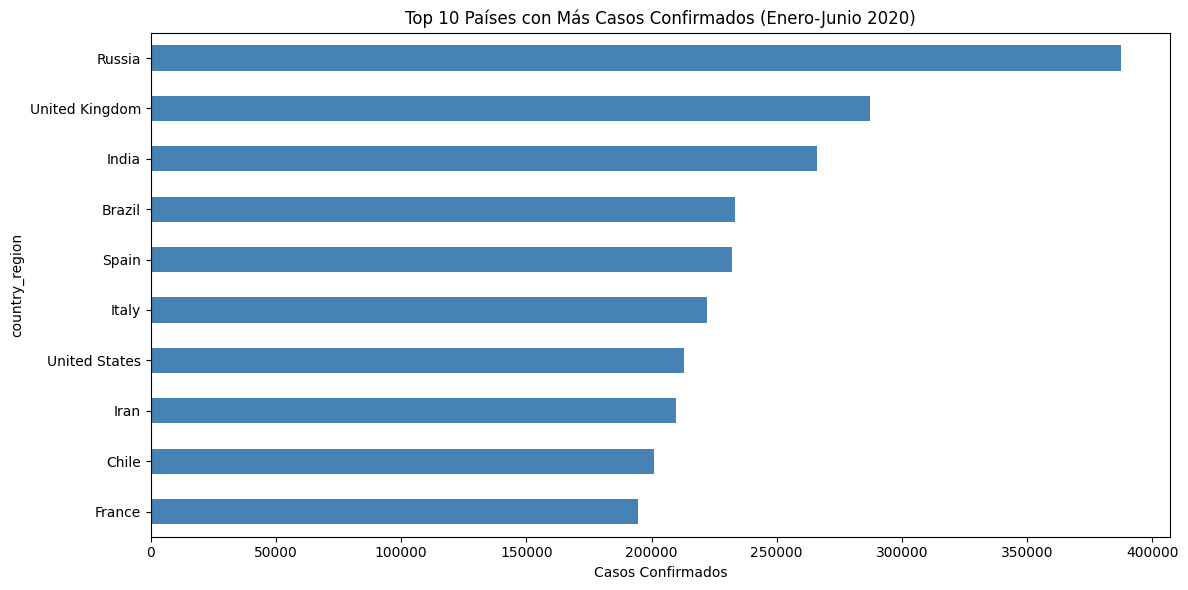

In [30]:
# 1. ¿Cuáles son los 10 países con más casos confirmados acumulados durante el semestre?
top_10_paises = df_6meses.groupby('country_region')['confirmed'].max().sort_values(ascending=False).head(10)
print("Top 10 países con más casos confirmados:")
print(top_10_paises)

plt.figure(figsize=(12, 6))
top_10_paises.plot(kind='barh', color='steelblue')
plt.xlabel('Casos Confirmados')
plt.title('Top 10 Países con Más Casos Confirmados (Enero-Junio 2020)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Top 10 países con mayor tasa de letalidad (mínimo 1000 casos):
     country_region  confirmed  deaths  letalidad
211  United Kingdom     287399   48111  16.740142
18          Belgium      60810    9713  15.972702
69           France     194534   29651  15.242066
100           Italy     222104   31106  14.005151
92          Hungary       4107     573  13.951790
143     Netherlands      49722    6095  12.258155
133          Mexico      47144    5656  11.997285
187           Spain     232128   27104  11.676317
192          Sweden      37814    4403  11.643836
157            Peru     147372   16893  11.462829


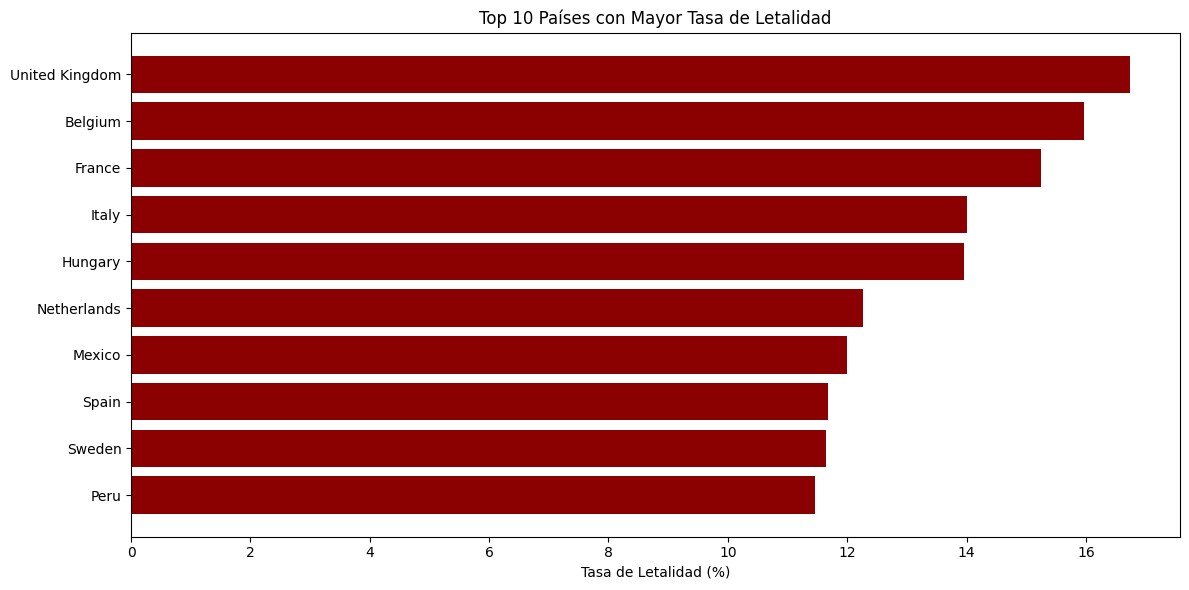

In [31]:
# 2. ¿Qué países presentan mayor tasa de letalidad (Deaths / Confirmed * 100)?
paises_letalidad = df_6meses.groupby('country_region').agg({
    'confirmed': 'max',
    'deaths': 'max'
}).reset_index()

paises_letalidad['letalidad'] = (paises_letalidad['deaths'] / paises_letalidad['confirmed'] * 100).fillna(0)
paises_letalidad = paises_letalidad[paises_letalidad['confirmed'] >= 1000]
top_letalidad = paises_letalidad.sort_values('letalidad', ascending=False).head(10)

print("Top 10 países con mayor tasa de letalidad (mínimo 1000 casos):")
print(top_letalidad[['country_region', 'confirmed', 'deaths', 'letalidad']])

plt.figure(figsize=(12, 6))
plt.barh(top_letalidad['country_region'], top_letalidad['letalidad'], color='darkred')
plt.xlabel('Tasa de Letalidad (%)')
plt.title('Top 10 Países con Mayor Tasa de Letalidad')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [32]:
# 3. ¿Cuántos países no registran recuperados en los datos analizados?
paises_sin_recuperados = df_6meses.groupby('country_region')['recovered'].max()
paises_sin_recuperados = paises_sin_recuperados[paises_sin_recuperados == 0]

print(f"Países sin recuperados registrados: {len(paises_sin_recuperados)}")
print(f"\nLista de países:")
print(paises_sin_recuperados.index.tolist())

Países sin recuperados registrados: 31

Lista de países:
['Antarctica', 'Bahamas, The', 'Cape Verde', 'Czech Republic', 'East Timor', 'Faroe Islands', 'Gambia, The', 'Gibraltar', 'Greenland', 'Guadeloupe', 'Guam', 'Guernsey', 'Jersey', 'Kiribati', 'Korea, North', 'MS Zaandam', 'Martinique', 'Mayotte', 'Nauru', 'Palau', 'Puerto Rico', 'Republic of the Congo', 'Reunion', 'Saint Barthelemy', 'Samoa', 'Summer Olympics 2020', 'The Bahamas', 'The Gambia', 'Tonga', 'Tuvalu', 'Winter Olympics 2022']


Top 10 países latinoamericanos con más casos activos en junio 2020:
1. Brazil: 473,441 casos activos
2. Peru: 84,802 casos activos
3. Chile: 59,099 casos activos
4. Colombia: 40,719 casos activos
5. Argentina: 32,549 casos activos
6. Mexico: 24,387 casos activos
7. Ecuador: 22,378 casos activos
8. Bolivia: 19,243 casos activos
9. Panama: 12,084 casos activos
10. Honduras: 12,077 casos activos


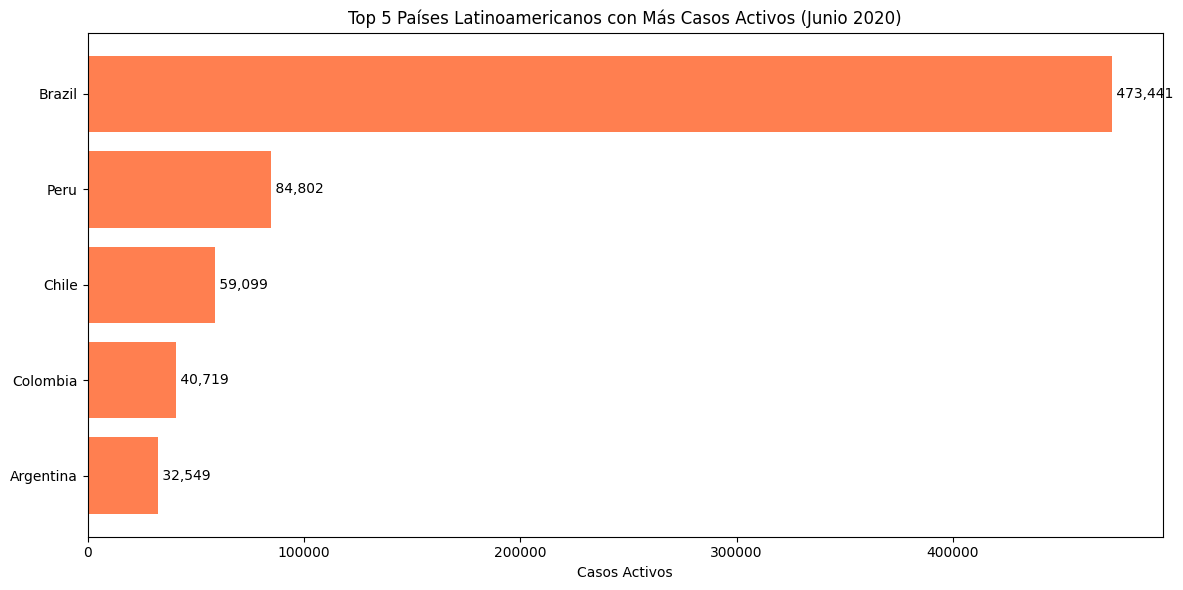

In [33]:
# 4. ¿Qué país latinoamericano presenta la mayor cantidad de casos activos en junio 2020?
paises_latam = ['Brazil', 'Mexico', 'Argentina', 'Chile', 'Peru', 'Colombia', 'Venezuela', 
                'Ecuador', 'Bolivia', 'Paraguay', 'Uruguay', 'Costa Rica', 'Panama', 
                'Dominican Republic', 'Guatemala', 'Honduras', 'El Salvador', 'Nicaragua', 'Cuba']

df_junio = df_6meses[df_6meses['date'].dt.month == 6]
latam_junio = df_junio[df_junio['country_region'].isin(paises_latam)]
latam_casos = latam_junio.groupby(['country_region', 'date'])['active_cases'].sum().reset_index()
latam_max = latam_casos.groupby('country_region')['active_cases'].max().sort_values(ascending=False)

print("Top 10 países latinoamericanos con más casos activos en junio 2020:")
for i, (pais, casos) in enumerate(latam_max.head(10).items(), 1):
    print(f"{i}. {pais}: {int(casos):,} casos activos")

plt.figure(figsize=(12, 6))
top_5 = latam_max.head(5)
plt.barh(range(len(top_5)), top_5.values, color='coral')
plt.yticks(range(len(top_5)), top_5.index)
plt.xlabel('Casos Activos')
plt.title('Top 5 Países Latinoamericanos con Más Casos Activos (Junio 2020)')
plt.gca().invert_yaxis()
for i, v in enumerate(top_5.values):
    plt.text(v, i, f' {int(v):,}', va='center')
plt.tight_layout()
plt.show()

Casos al inicio: 1
Casos al final: 250,767


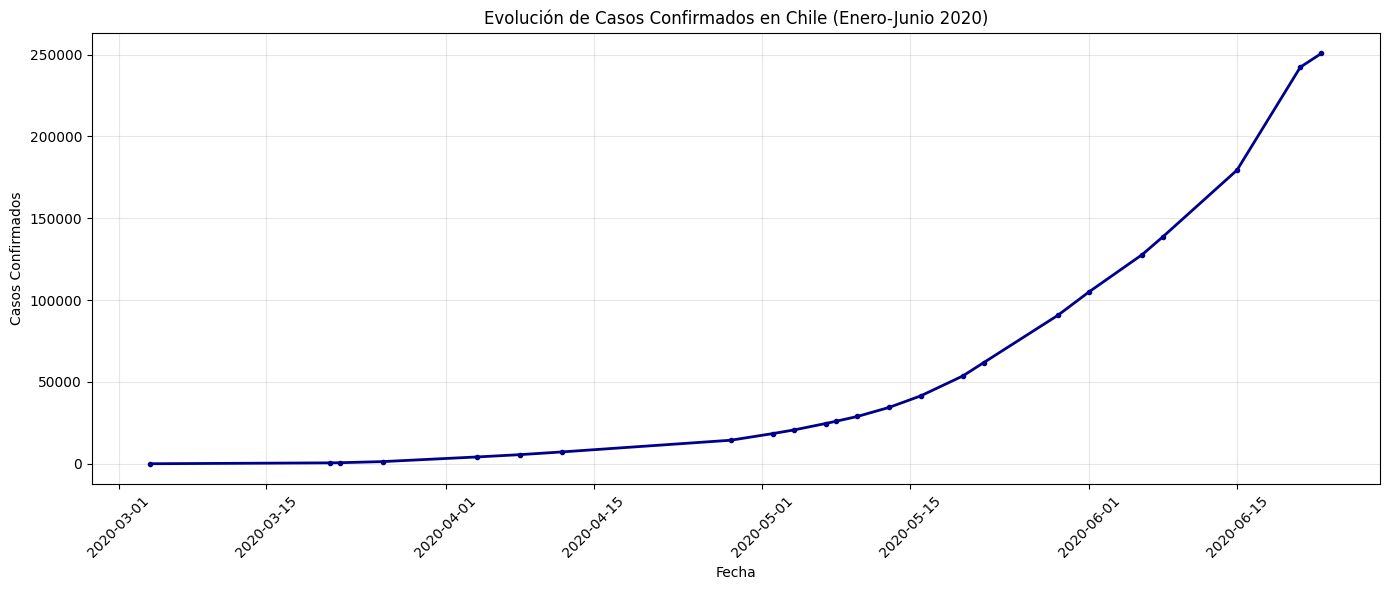

In [34]:
# 5. ¿Cómo evolucionaron los casos confirmados en Chile entre enero y junio?
chile_data = df_6meses[df_6meses['country_region'] == 'Chile'].groupby('date')['confirmed'].sum().reset_index()

print(f"Casos al inicio: {chile_data['confirmed'].iloc[0]:,}")
print(f"Casos al final: {chile_data['confirmed'].iloc[-1]:,}")

plt.figure(figsize=(14, 6))
plt.plot(chile_data['date'], chile_data['confirmed'], marker='o', linewidth=2, markersize=3, color='darkblue')
plt.xlabel('Fecha')
plt.ylabel('Casos Confirmados')
plt.title('Evolución de Casos Confirmados en Chile (Enero-Junio 2020)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Fecha con más nuevos casos: 2020-04-28
Nuevos casos ese día: 1,282,871


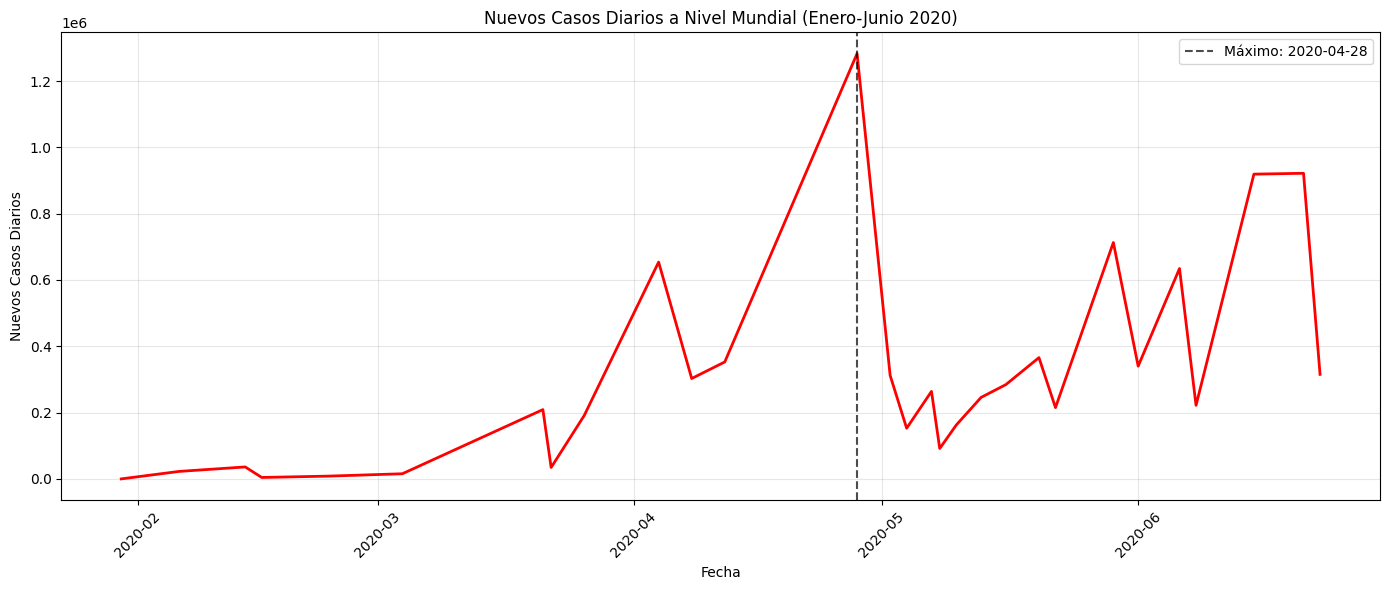

In [35]:
# 6. ¿Cuál fue la fecha con más nuevos casos a nivel mundial durante este período?
casos_diarios = df_6meses.groupby('date')['confirmed'].sum().reset_index()
casos_diarios['nuevos_casos'] = casos_diarios['confirmed'].diff().fillna(0)
fecha_max = casos_diarios.loc[casos_diarios['nuevos_casos'].idxmax()]

print(f"Fecha con más nuevos casos: {fecha_max['date'].strftime('%Y-%m-%d')}")
print(f"Nuevos casos ese día: {int(fecha_max['nuevos_casos']):,}")

plt.figure(figsize=(14, 6))
plt.plot(casos_diarios['date'], casos_diarios['nuevos_casos'], linewidth=2, color='red')
plt.axvline(fecha_max['date'], color='black', linestyle='--', alpha=0.7, label=f"Máximo: {fecha_max['date'].strftime('%Y-%m-%d')}")
plt.xlabel('Fecha')
plt.ylabel('Nuevos Casos Diarios')
plt.title('Nuevos Casos Diarios a Nivel Mundial (Enero-Junio 2020)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Correlación de Pearson: 0.7371
R² (coeficiente de determinación): 0.5433
P-value: 0.000000


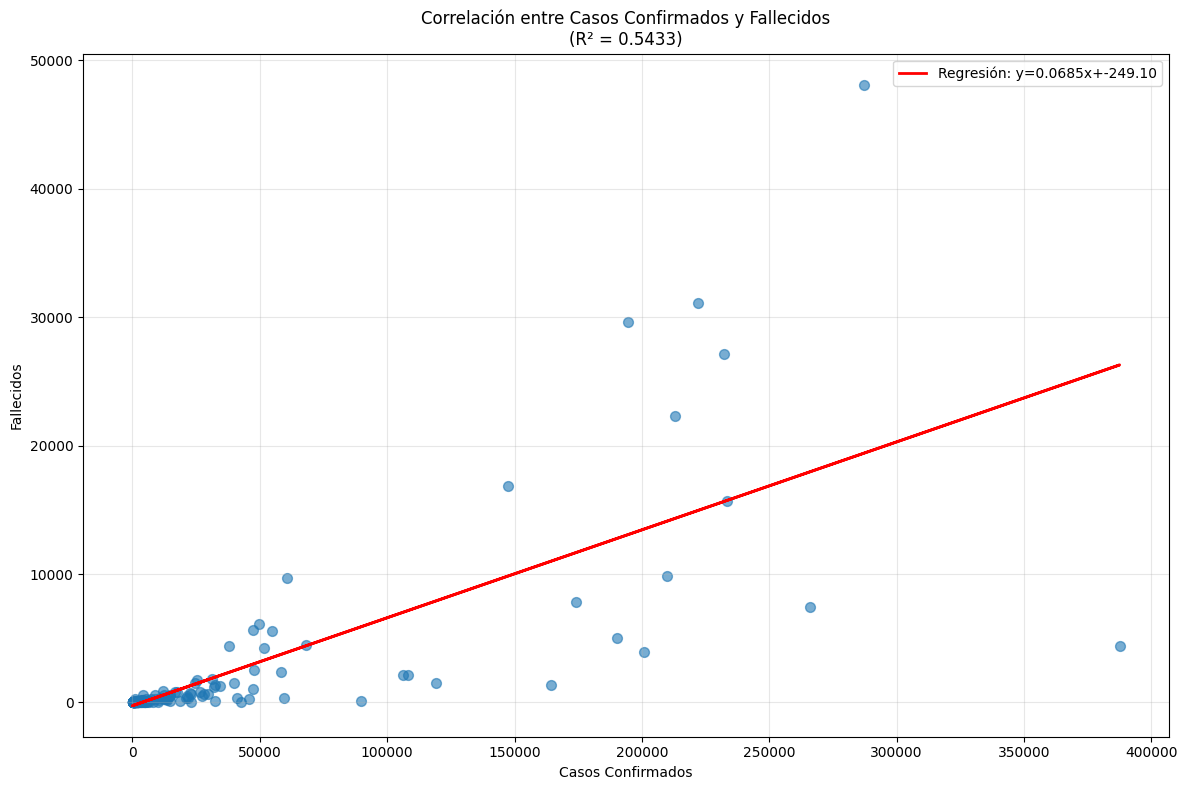

In [42]:
# 7. ¿Existe correlación entre casos confirmados y fallecidos? (gráfico de dispersión + regresión)
from scipy import stats

paises_final = df_6meses.groupby('country_region').agg({
    'confirmed': 'max',
    'deaths': 'max'
}).reset_index()

paises_final = paises_final[(paises_final['confirmed'] > 0) & (paises_final['deaths'] > 0)]

correlacion = paises_final['confirmed'].corr(paises_final['deaths'])
slope, intercept, r_value, p_value, std_err = stats.linregress(paises_final['confirmed'], paises_final['deaths'])

print(f"Correlación de Pearson: {correlacion:.4f}")
print(f"R² (coeficiente de determinación): {r_value**2:.4f}")
print(f"P-value: {p_value:.6f}")

plt.figure(figsize=(12, 8))
plt.scatter(paises_final['confirmed'], paises_final['deaths'], alpha=0.6, s=50)
plt.plot(paises_final['confirmed'], slope * paises_final['confirmed'] + intercept, 
         'r-', linewidth=2, label=f'Regresión: y={slope:.4f}x+{intercept:.2f}')
plt.xlabel('Casos Confirmados')
plt.ylabel('Fallecidos')
plt.title(f'Correlación entre Casos Confirmados y Fallecidos\n(R² = {r_value**2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Interpretación:
El gráfico muestra que existe una correlación positiva moderada-alta (0.7371) entre
los casos confirmados y las muertes. Esto significa que a medida que aumentan los casos
confirmados, también tienden a aumentar las muertes. La línea roja de regresión muestra
esta tendencia general. El R² de 0.5433 indica que aproximadamente el 54.3%
de la variación en las muertes puede explicarse por el número de casos confirmados.

Top 10 países con mayor crecimiento porcentual Mayo-Junio:
Nepal: 733.25% (de 1,212 a 10,099)
Mauritania: 678.25% (de 423 a 3,292)
Iraq: 487.47% (de 5,873 a 34,502)
Libya: 441.53% (de 118 a 639)
Ethiopia: 400.83% (de 968 a 4,848)
Haiti: 294.77% (de 1,320 a 5,211)
South Africa: 262.89% (de 29,240 a 106,108)
Zimbabwe: 252.35% (de 149 a 525)
Yemen: 250.53% (de 283 a 992)
Central African Republic: 249.08% (de 874 a 3,051)


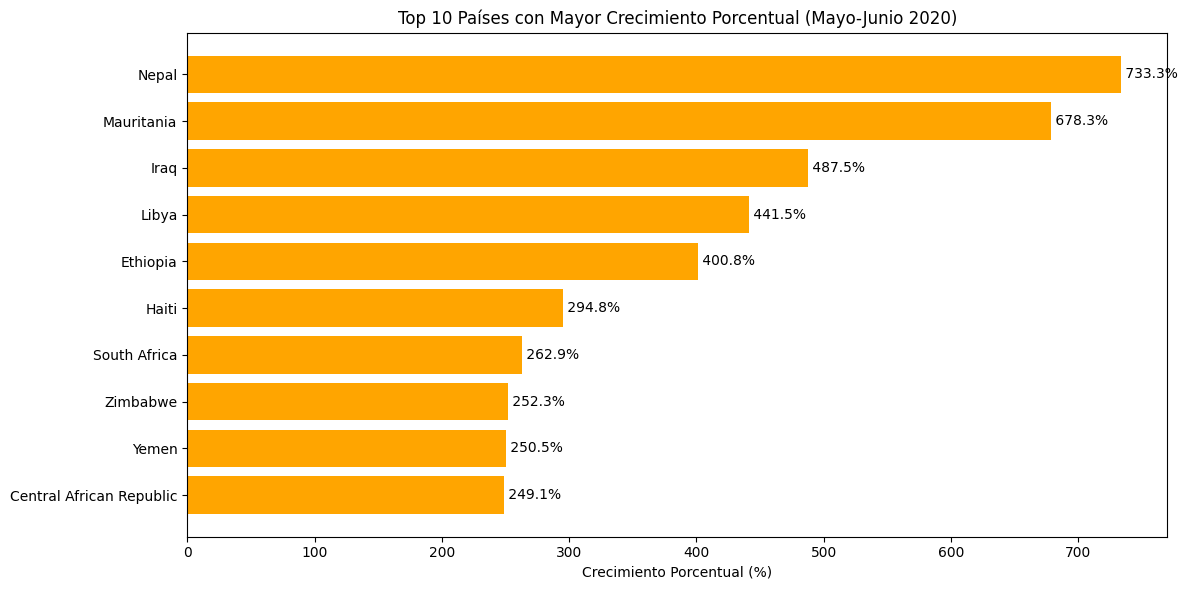

In [37]:
# 8. Top 10 de países con mayor crecimiento porcentual de casos entre mayo y junio
df_mayo = df_6meses[df_6meses['date'].dt.month == 5].groupby('country_region')['confirmed'].max()
df_junio = df_6meses[df_6meses['date'].dt.month == 6].groupby('country_region')['confirmed'].max()

crecimiento = pd.DataFrame({
    'mayo': df_mayo,
    'junio': df_junio
}).dropna()

crecimiento = crecimiento[crecimiento['mayo'] >= 100]
crecimiento['crecimiento_porcentual'] = ((crecimiento['junio'] - crecimiento['mayo']) / crecimiento['mayo'] * 100)
top_crecimiento = crecimiento.sort_values('crecimiento_porcentual', ascending=False).head(10)

print("Top 10 países con mayor crecimiento porcentual Mayo-Junio:")
for idx, row in top_crecimiento.iterrows():
    print(f"{idx}: {row['crecimiento_porcentual']:.2f}% (de {int(row['mayo']):,} a {int(row['junio']):,})")

plt.figure(figsize=(12, 6))
plt.barh(range(len(top_crecimiento)), top_crecimiento['crecimiento_porcentual'], color='orange')
plt.yticks(range(len(top_crecimiento)), top_crecimiento.index)
plt.xlabel('Crecimiento Porcentual (%)')
plt.title('Top 10 Países con Mayor Crecimiento Porcentual (Mayo-Junio 2020)')
plt.gca().invert_yaxis()
for i, v in enumerate(top_crecimiento['crecimiento_porcentual']):
    plt.text(v, i, f' {v:.1f}%', va='center')
plt.tight_layout()
plt.show()

In [40]:
# 9. Identificar países con rebrote (un día sin casos y luego un incremento posterior)
paises_rebrote = []

for pais in df_6meses['country_region'].unique():
    if pd.isna(pais):
        continue
    
    datos_pais = df_6meses[df_6meses['country_region'] == pais].sort_values('date')
    casos_diarios = datos_pais.groupby('date')['confirmed'].sum()
    
    tuvo_cero = False
    for i in range(len(casos_diarios) - 1):
        if casos_diarios.iloc[i] == 0:
            tuvo_cero = True
        elif tuvo_cero and casos_diarios.iloc[i] > 0 and casos_diarios.iloc[i+1] > casos_diarios.iloc[i]:
            paises_rebrote.append({
                'pais': pais,
                'fecha_cero': casos_diarios.index[i-1] if i > 0 else casos_diarios.index[0],
                'fecha_rebrote': casos_diarios.index[i+1],
                'casos_rebrote': int(casos_diarios.iloc[i+1])
            })
            break

df_rebrotes = pd.DataFrame(paises_rebrote)

print(f"Países identificados con patrón de rebrote: {len(df_rebrotes)}")
print("\nPaíses con rebrote:")
print(df_rebrotes.head(5).to_string(index=False))

Países identificados con patrón de rebrote: 5

Países con rebrote:
          pais fecha_cero fecha_rebrote  casos_rebrote
   New Zealand 2020-02-24    2020-03-21             52
      Malaysia 2020-03-21    2020-03-26           2031
United Kingdom 2020-01-30    2020-02-14              9
       Ukraine 2020-02-24    2020-03-21             47
     Lithuania 2020-03-04    2020-03-22             30


In [39]:
# 10. Generar un reporte de perfilado automático con ydata-profiling
from ydata_profiling import ProfileReport

# Crear una muestra del dataset para el reporte (para optimizar tiempo de generación)
df_sample = df_6meses.sample(n=min(10000, len(df_6meses)), random_state=42)

print("Generando reporte de perfilado automático...")
print(f"Muestra de datos: {len(df_sample):,} registros")

profile = ProfileReport(
    df_sample,
    title="Reporte de Perfilado COVID-19 (Enero-Junio 2020)",
    explorative=True,
    minimal=False
)

# Guardar el reporte en HTML
output_path = "../reports/covid19_data_profile.html"
profile.to_file(output_path)
print(f"\n✅ Reporte generado exitosamente: {output_path}")
print("Abre el archivo HTML en tu navegador para ver el reporte completo.")

# Mostrar el reporte en el notebook (opcional)
profile.to_notebook_iframe()

Generando reporte de perfilado automático...
Muestra de datos: 10,000 registros


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 226.43it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Reporte generado exitosamente: ../reports/covid19_data_profile.html
Abre el archivo HTML en tu navegador para ver el reporte completo.
